Comandos GIT para facilitar interagir com o repositório

In [118]:
#!git clone https://github.com/gcerbaro/DSFinal_global_cancer_patients.git
%cd DSFinal_global_cancer_patients
#!git pull

[WinError 2] O sistema não pode encontrar o arquivo especificado: 'DSFinal_global_cancer_patients'
d:\Facul\Setimo Semestre\DS\DSFinal_global_cancer_patients\src


Instalacao e importacao dos pacotes necessarios

In [119]:
#!pip install pandas
#!pip install matplotlib
#!pip install seaborn
#!pip install scikit-learn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

In [120]:
df = pd.read_csv("../dataset/global_cancer_patients_2015_2024.csv")
df.head(5)

,Patient_ID,Age,Gender,Country_Region,Year,Genetic_Risk,Air_Pollution,Alcohol_Use,Smoking,Obesity_Level,Cancer_Type,Cancer_Stage,Treatment_Cost_USD,Survival_Years,Target_Severity_Score
0,PT0000000,71,Male,UK,2021,6.4,2.8,9.5,0.9,8.7,Lung,Stage III,62913.44,5.9,4.92
1,PT0000001,34,Male,China,2021,1.3,4.5,3.7,3.9,6.3,Leukemia,Stage 0,12573.41,4.7,4.65
2,PT0000002,80,Male,Pakistan,2023,7.4,7.9,2.4,4.7,0.1,Breast,Stage II,6984.33,7.1,5.84
3,PT0000003,40,Male,UK,2015,1.7,2.9,4.8,3.5,2.7,Colon,Stage I,67446.25,1.6,3.12
4,PT0000004,43,Female,Brazil,2017,5.1,2.8,2.3,6.7,0.5,Skin,Stage III,77977.12,2.9,3.62


Limpeza e normalização dos dados

In [121]:
#Limpeza de valores nulos, duplicados e exclusao da coluna ID
df = df.dropna()
df = df.drop_duplicates()
df = df.drop(columns=['Patient_ID'])

#Verificacao de valores unicos
print("\nUnique Values for each non-numeric column:\n")
df_temp = df.select_dtypes(exclude=['number'])
df_temp['Year'] = df['Year']
for c in df_temp.columns:
    print(f"{c}:")
    print(df[c].unique())
    print('\n')



Unique Values for each non-numeric column:

Gender:
['Male' 'Female' 'Other']


Country_Region:
['UK' 'China' 'Pakistan' 'Brazil' 'Germany' 'Canada' 'USA' 'India'
 'Australia' 'Russia']


Cancer_Type:
['Lung' 'Leukemia' 'Breast' 'Colon' 'Skin' 'Cervical' 'Prostate' 'Liver']


Cancer_Stage:
['Stage III' 'Stage 0' 'Stage II' 'Stage I' 'Stage IV']


Year:
[2021 2023 2015 2017 2018 2022 2016 2024 2020 2019]




In [122]:
# Remocao de valores irreais para propria descricao do dataset
# Pessoa não pode ter sobrevivido mais do que sua idade
df = df[df["Survival_Years"] <= df["Age"]]

#Conversao de valores textuais para numericos
#Uso de One-Hot Encoding para variaveis nominais e map para variavel ordinal em sequencia

#Estagio do cancer
cancer_stage_map = {
    'Stage 0': 0,
    'Stage I': 1,
    'Stage II': 2,
    'Stage III': 3,
    'Stage IV': 4
}

df = pd.get_dummies(df, columns=[
    'Gender', 'Country_Region', 'Cancer_Type'])
df['Cancer_Stage'] = df['Cancer_Stage'].map(cancer_stage_map)


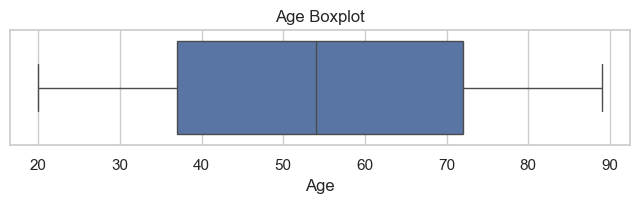

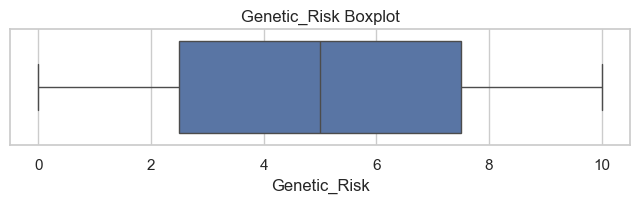

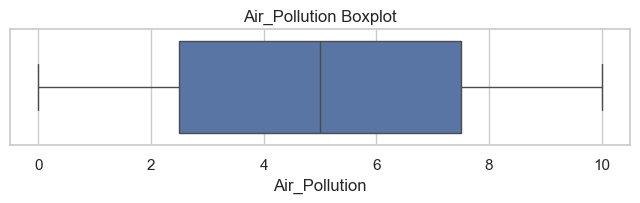

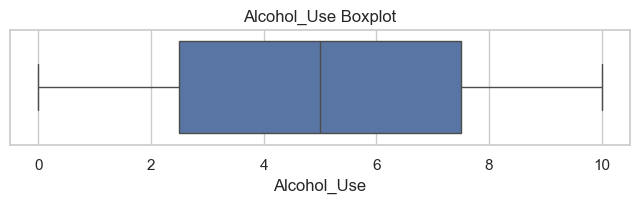

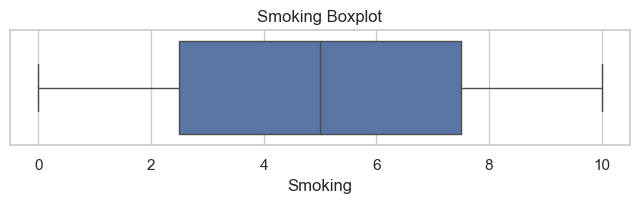

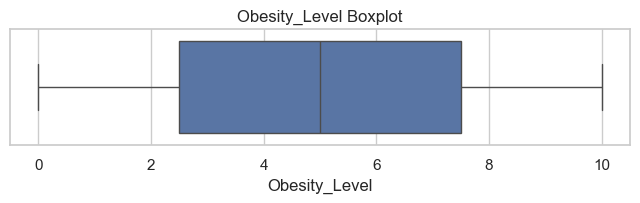

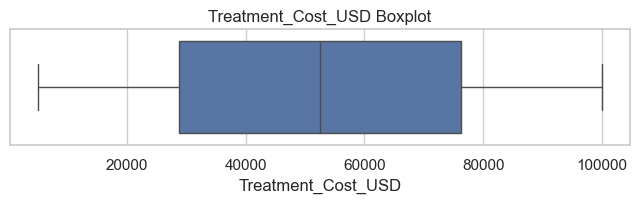

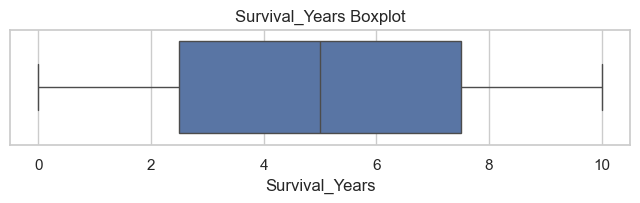

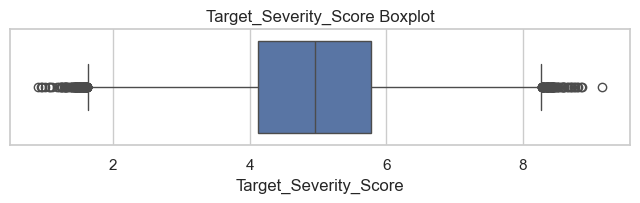

0 Outlier values removed from 'Age'
0 Outlier values removed from 'Genetic_Risk'
0 Outlier values removed from 'Air_Pollution'
0 Outlier values removed from 'Alcohol_Use'
0 Outlier values removed from 'Smoking'
0 Outlier values removed from 'Obesity_Level'
0 Outlier values removed from 'Treatment_Cost_USD'
0 Outlier values removed from 'Survival_Years'
151 Outlier values removed from 'Target_Severity_Score'


In [123]:
# Visualizacao dos dados numeros na busca por outliers
df_numeric_cols = df.select_dtypes(include=['int64', 'float64'])
df_numeric_cols = df_numeric_cols.drop(columns=['Year', 'Cancer_Stage'])

for col in df_numeric_cols:
    plt.figure(figsize=(8, 1.5))
    sns.boxplot(data=df, x=col)
    plt.title(f'{col} Boxplot')
    plt.show()

# Remocao dos outliers baseado no IQR
def clear_outliers(c):
    Q1 = df[c].quantile(0.25)
    Q3 = df[c].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    df_limpo = df[(df[c] >= lower_limit) & (df[c] <= upper_limit)]

    print(f"{df.shape[0] - df_limpo.shape[0]} Outlier values removed from '{c}'")
    return df_limpo

for c in df_numeric_cols:
    df = clear_outliers(c)

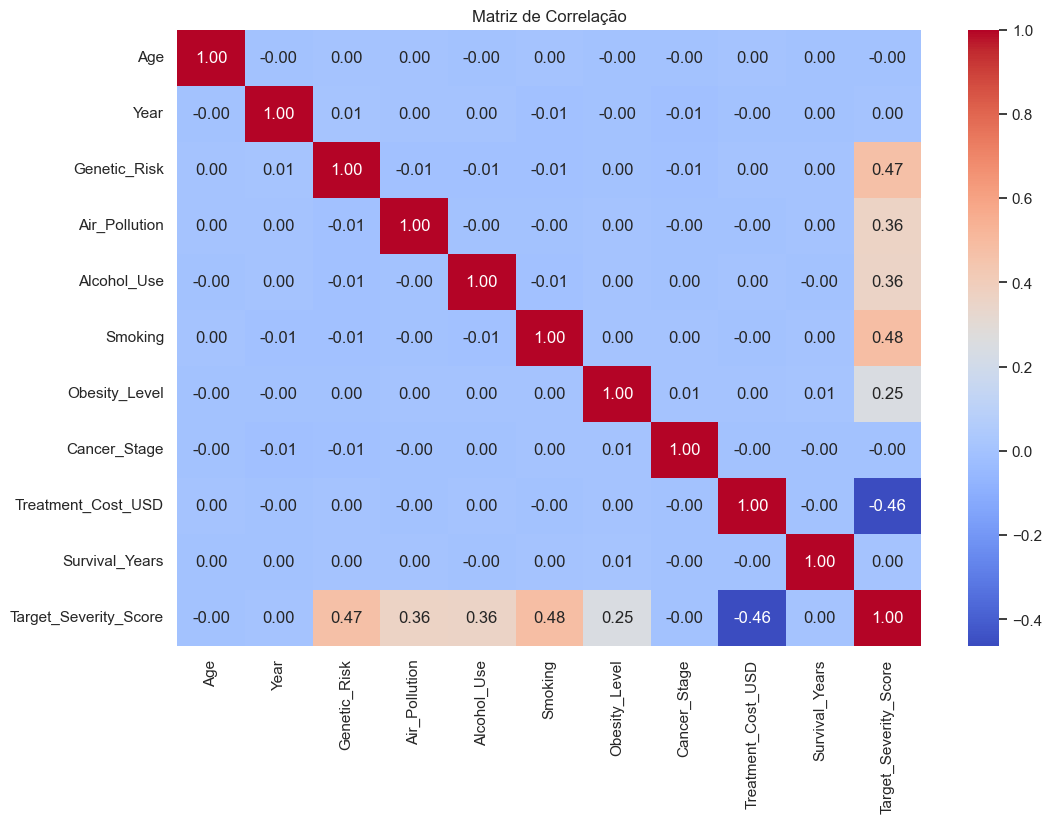

In [124]:
# Normalizacao dos dados com MixMaxScaler
# Transforma dados numeros entre valores de 0 a 1
scaler = MinMaxScaler()

for c in df_numeric_cols:
    df[c] = scaler.fit_transform(df[[c]])

df_temp = df.select_dtypes(include=['int64', 'float64'])

correlation_matrix = df_temp.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()

Random Forest Regression

In [125]:
X = df.drop(columns=['Target_Severity_Score'])
y = df['Target_Severity_Score']

# Divisão
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Avaliação
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.4f}')
print(f'R² Score: {r2:.4f}')

Mean Squared Error: 0.0007
R² Score: 0.9776


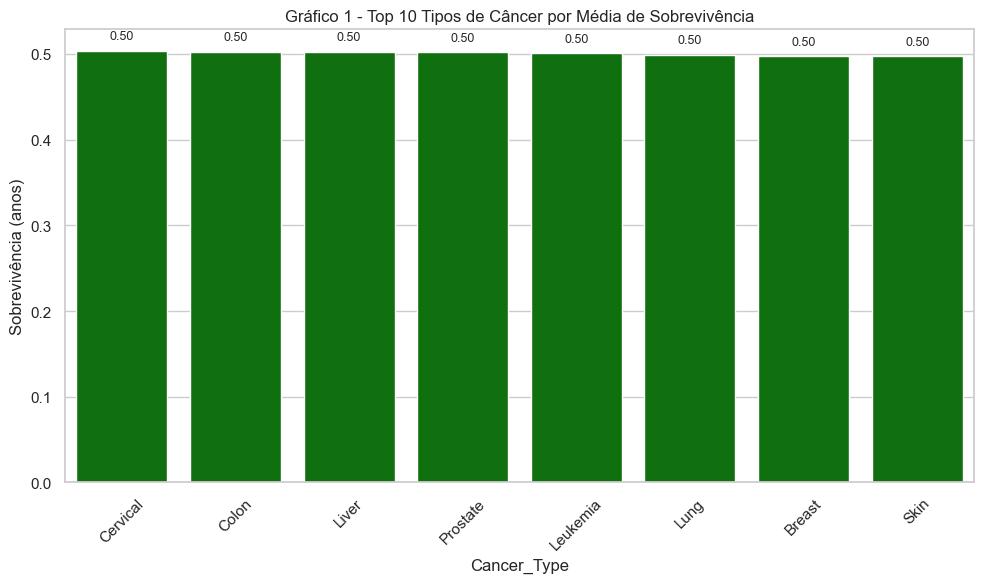

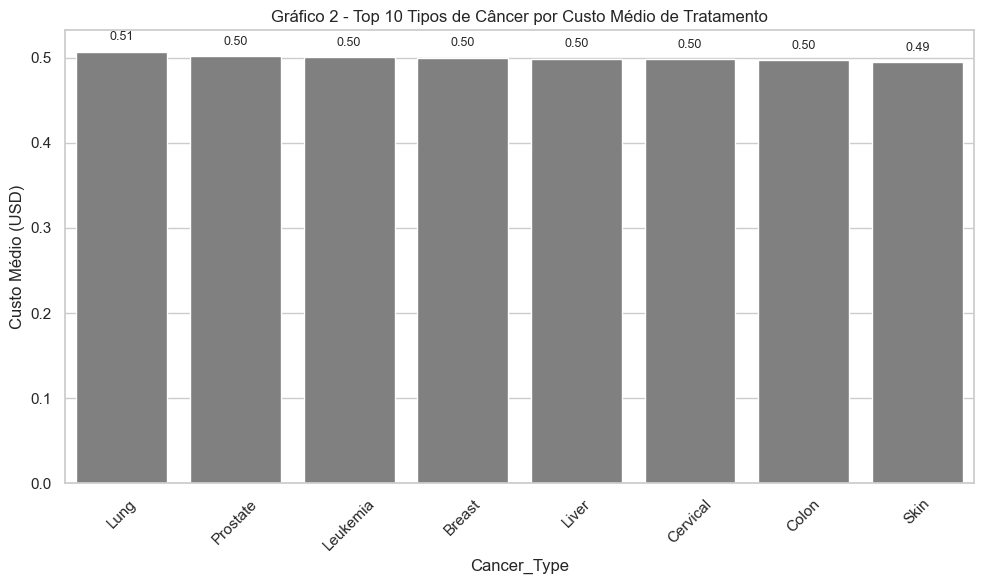

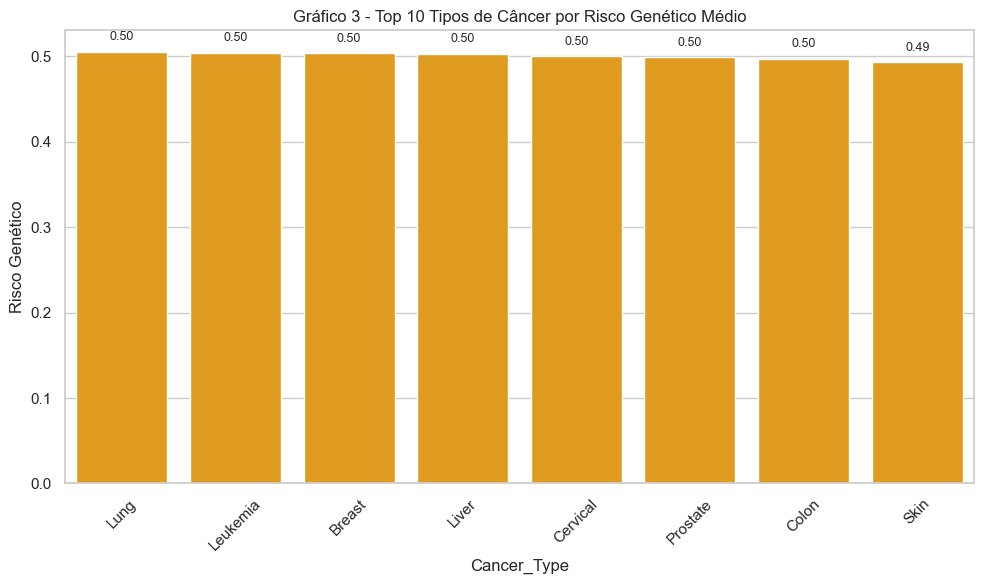

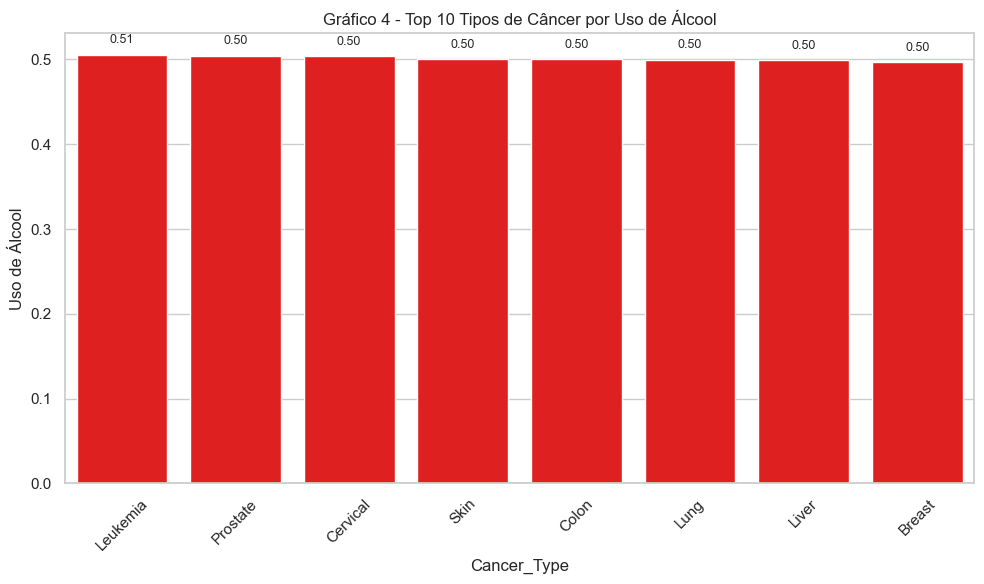

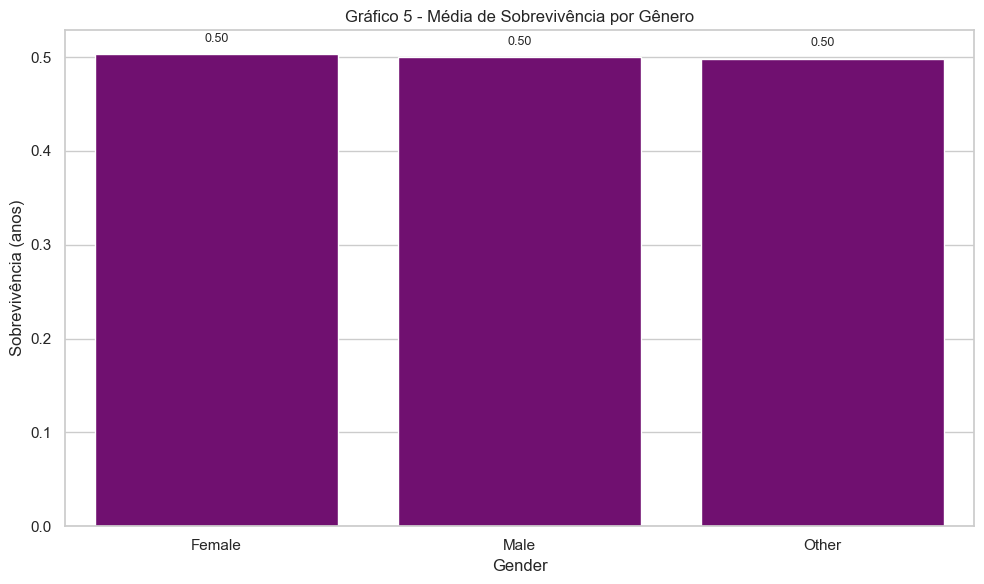

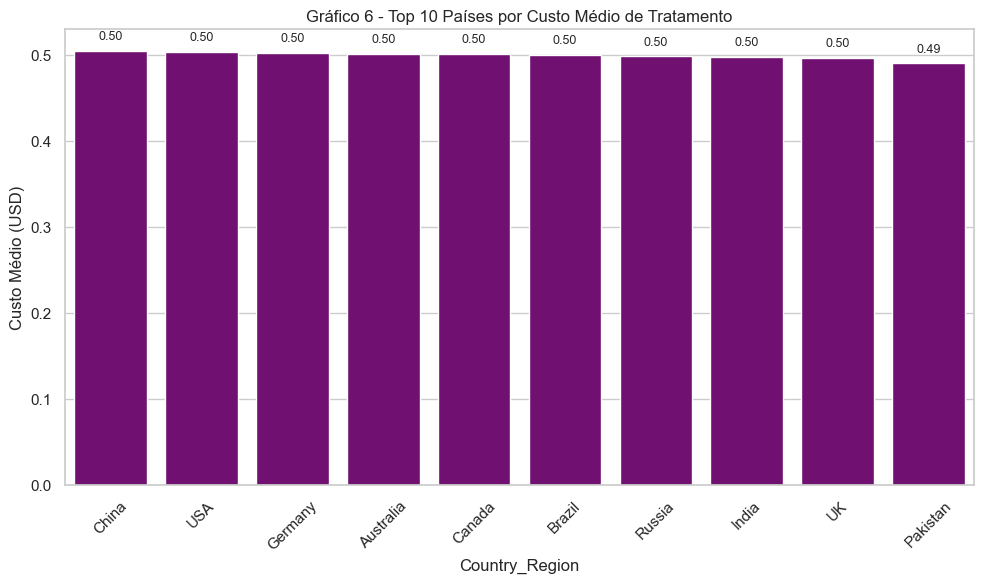

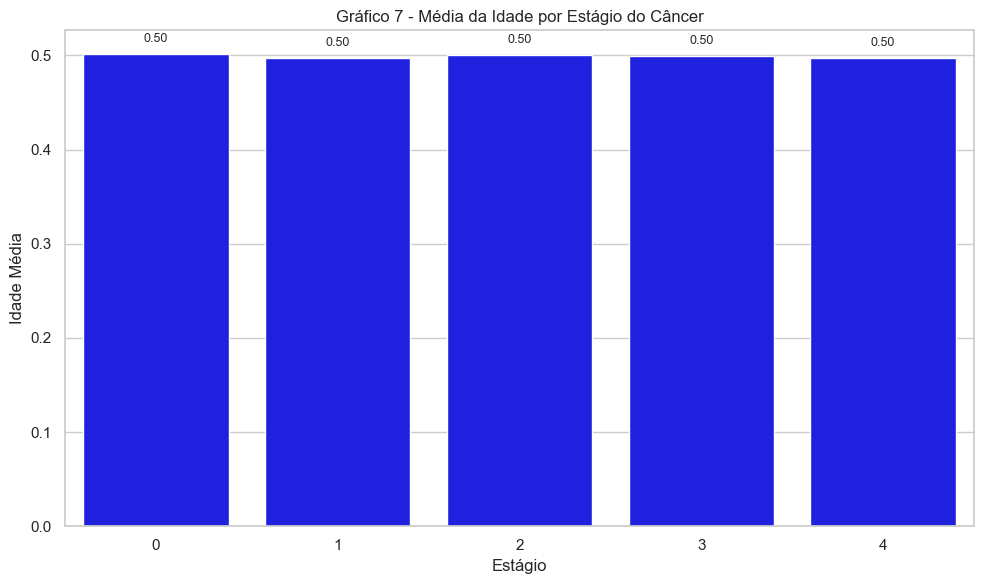

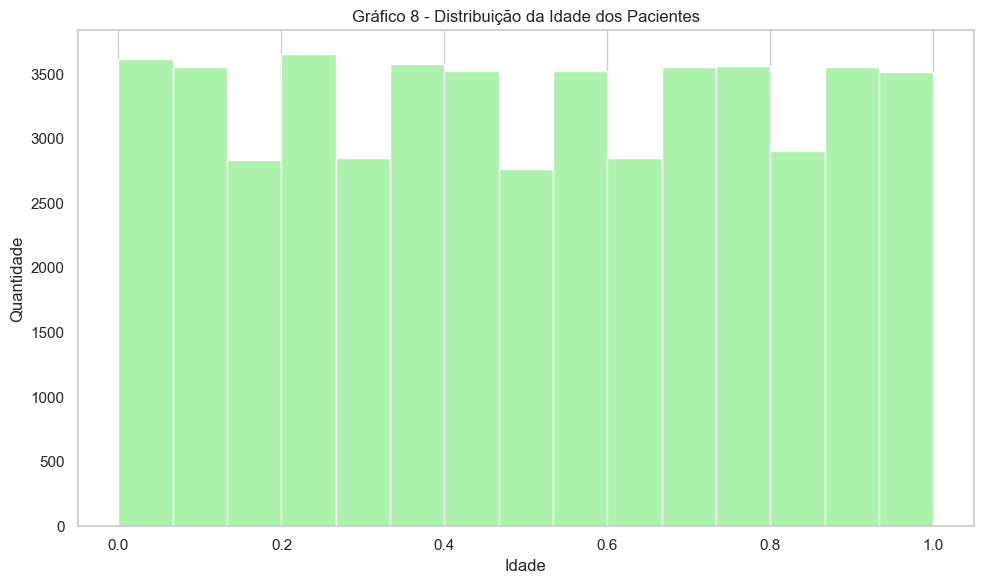

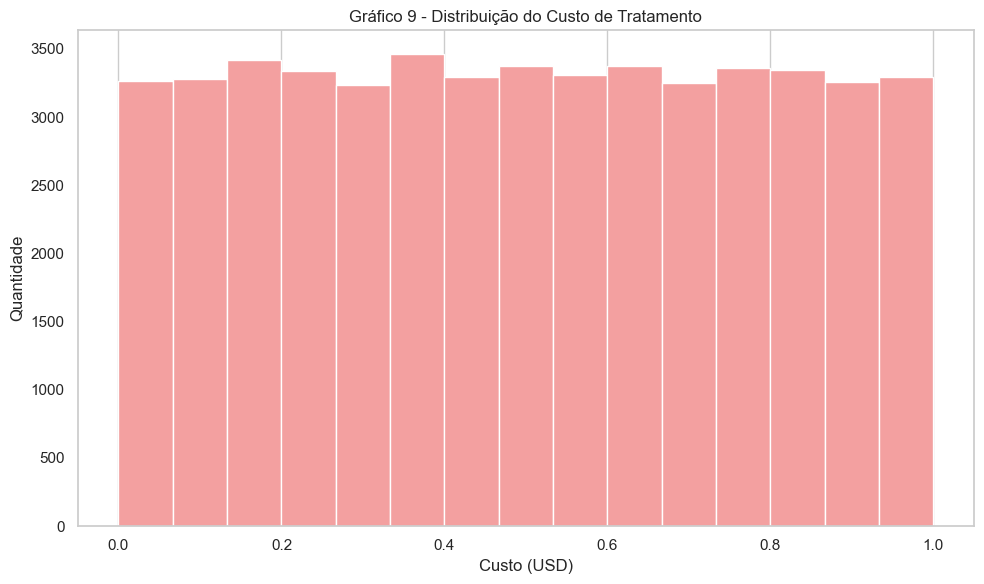

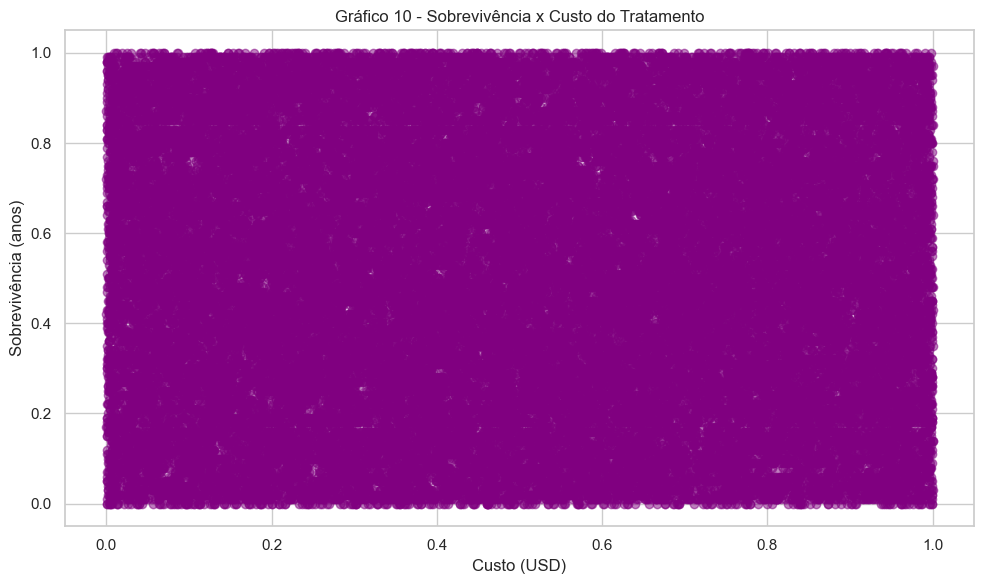

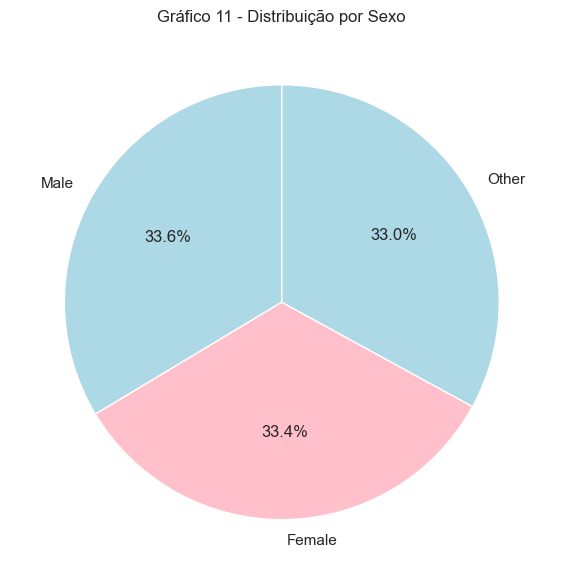

C:\Users\noobs\AppData\Local\Temp\ipykernel_14924\3759187318.py:158: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=corr_target.values, y=corr_target.index, palette=colors)


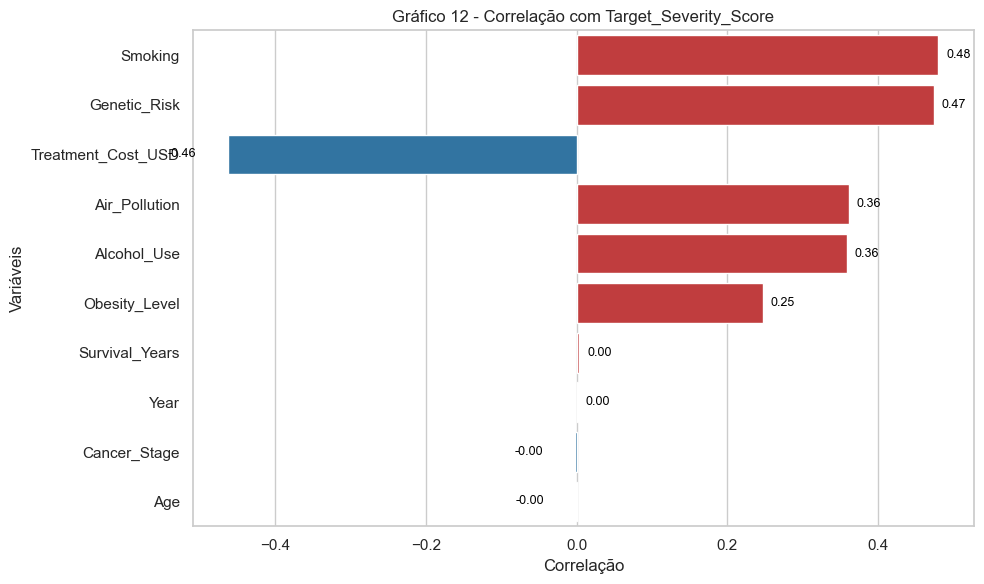

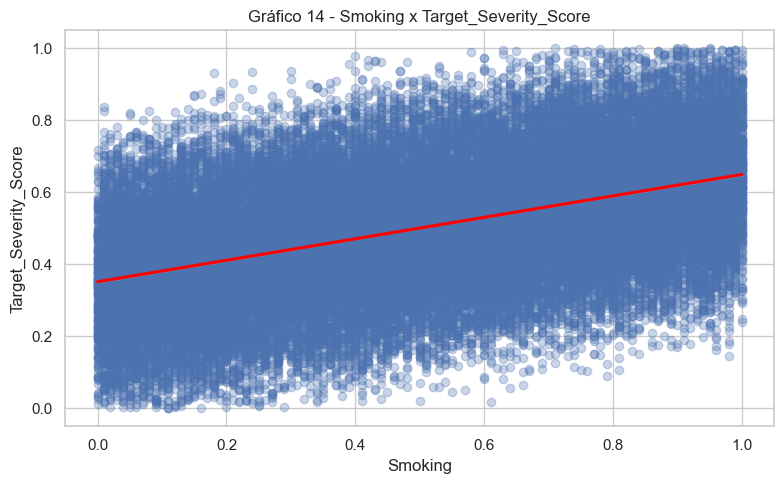

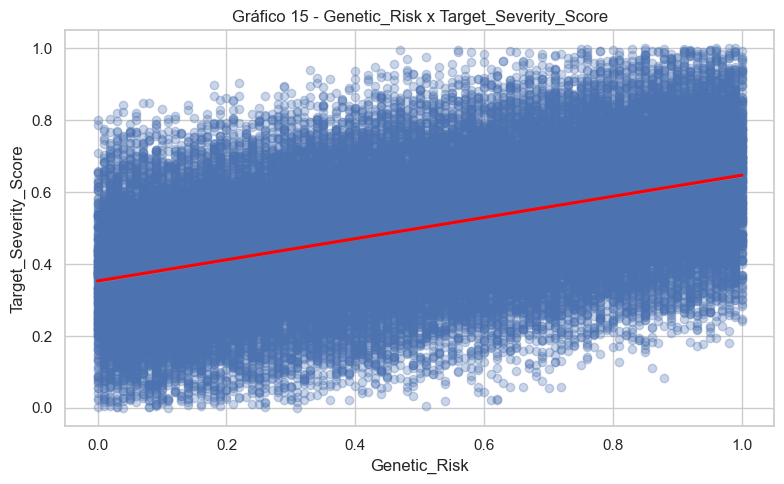

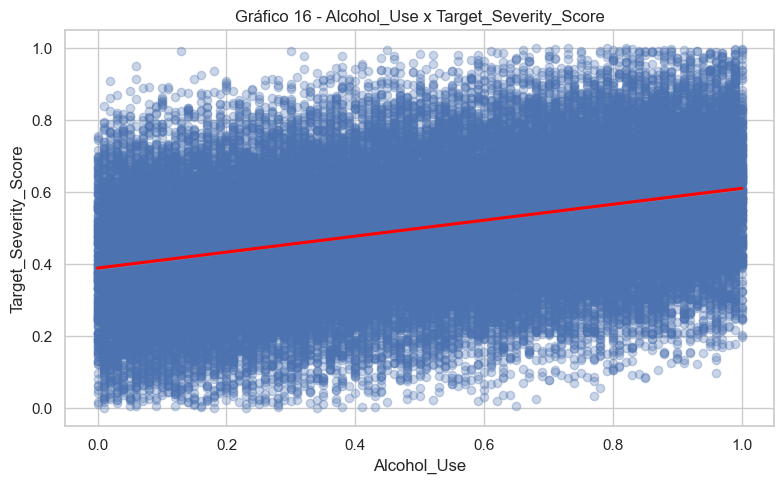

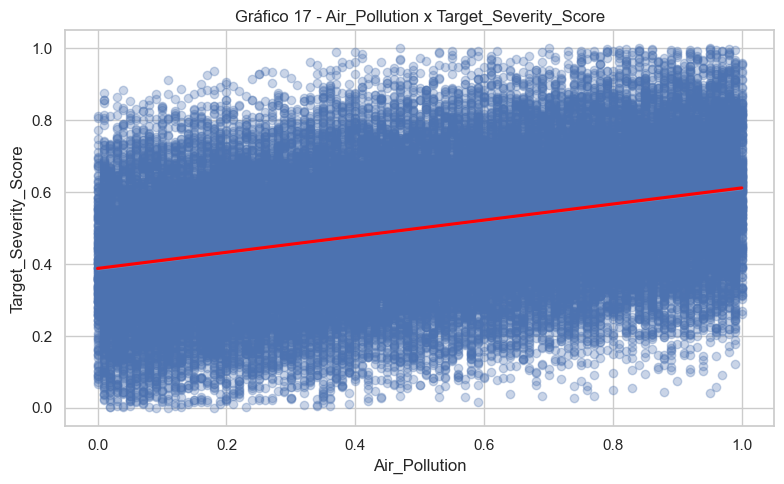

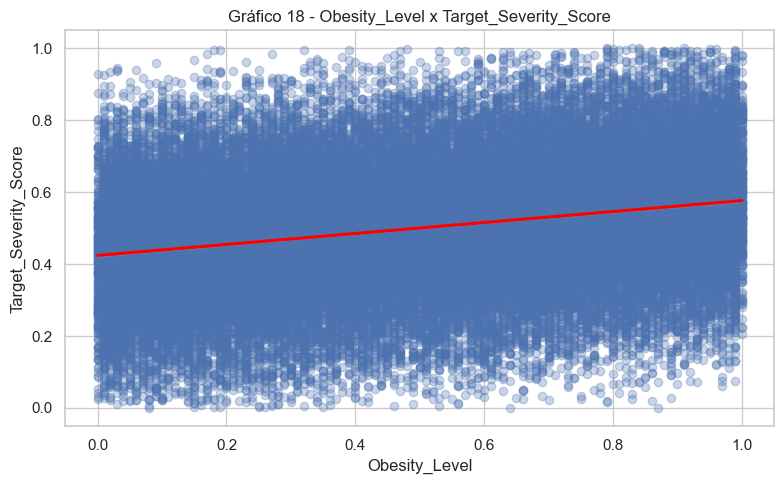

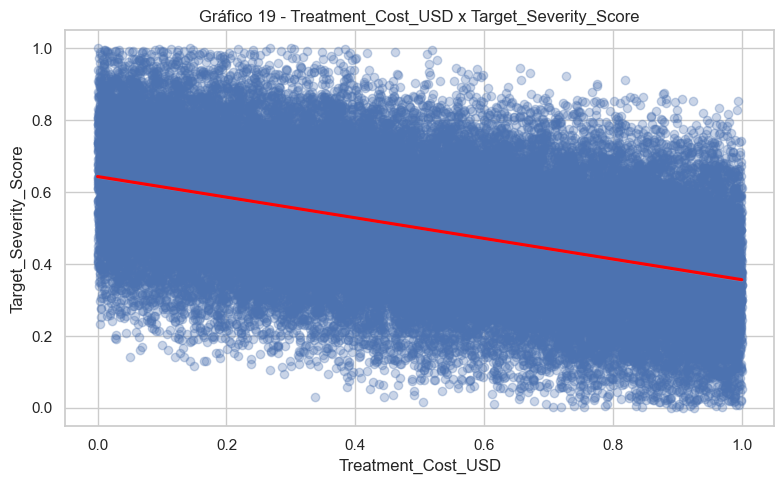

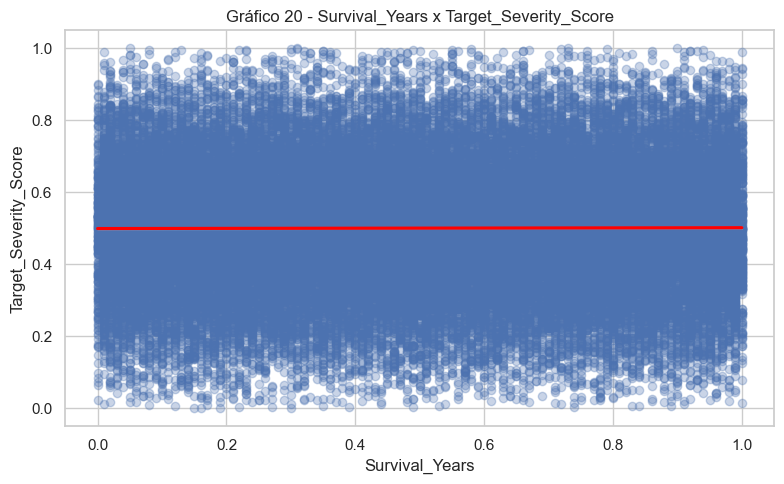

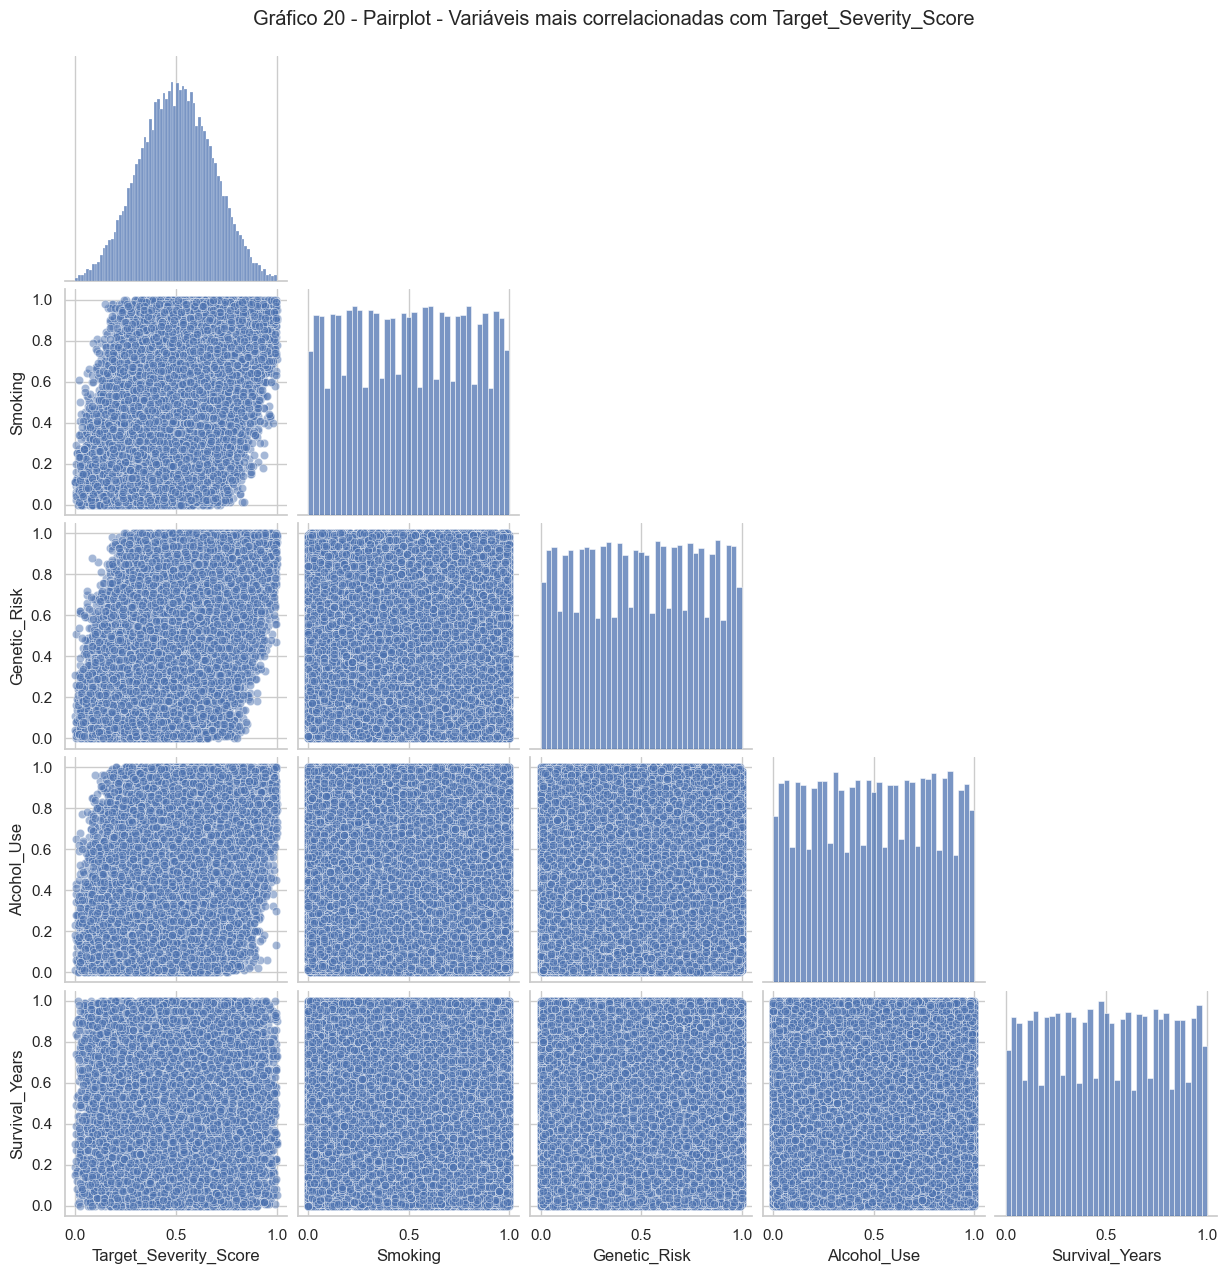

C:\Users\noobs\AppData\Local\Temp\ipykernel_14924\3759187318.py:205: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Smoking_Level', y='Target_Severity_Score', data=df, palette='Reds')


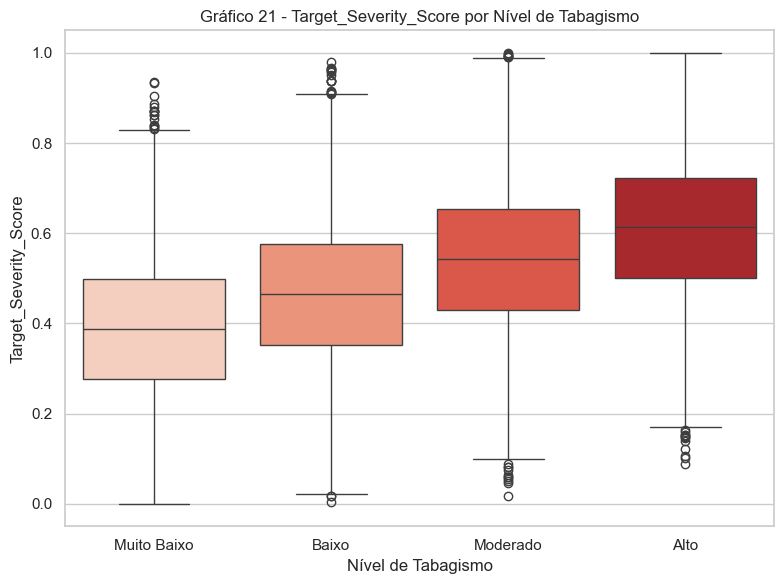

C:\Users\noobs\AppData\Local\Temp\ipykernel_14924\3759187318.py:215: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Genetic_Risk_Level', y='Target_Severity_Score', data=df, palette='Blues')


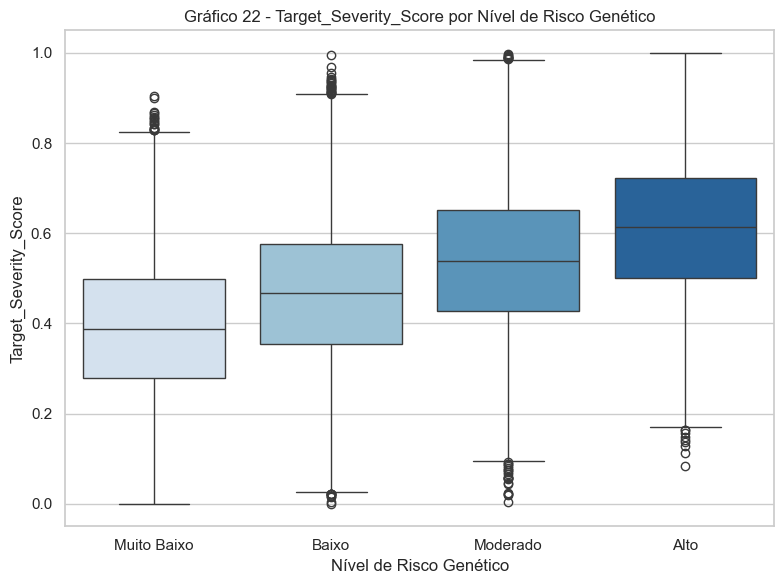

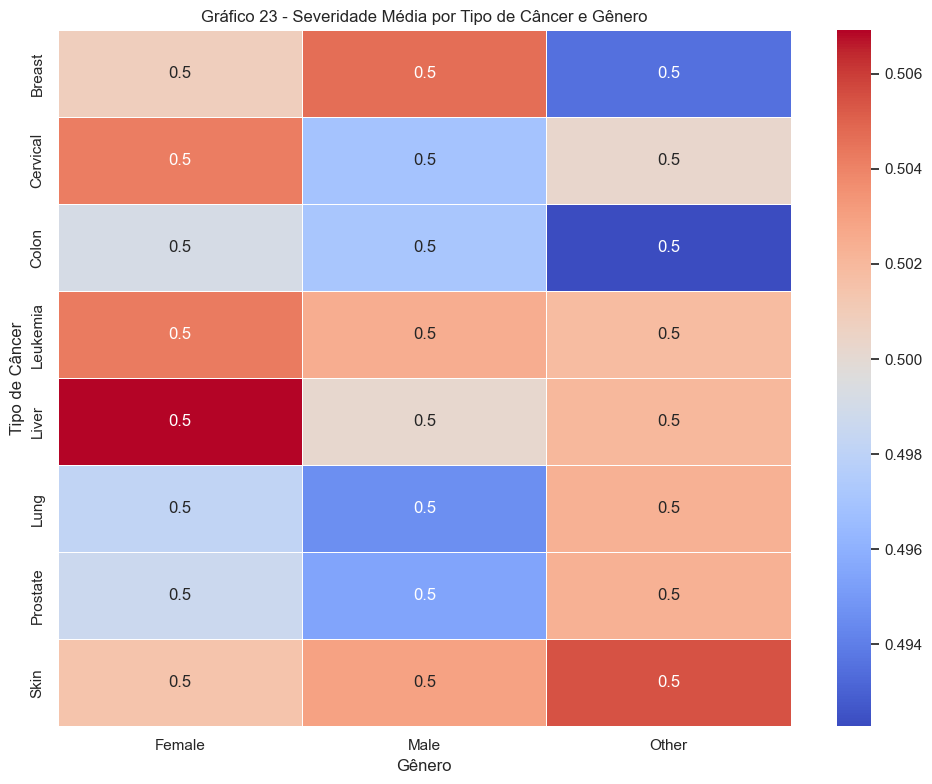

C:\Users\noobs\AppData\Local\Temp\ipykernel_14924\3759187318.py:234: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cancer_Stage', y='Survival_Years', data=df, palette='Pastel1')


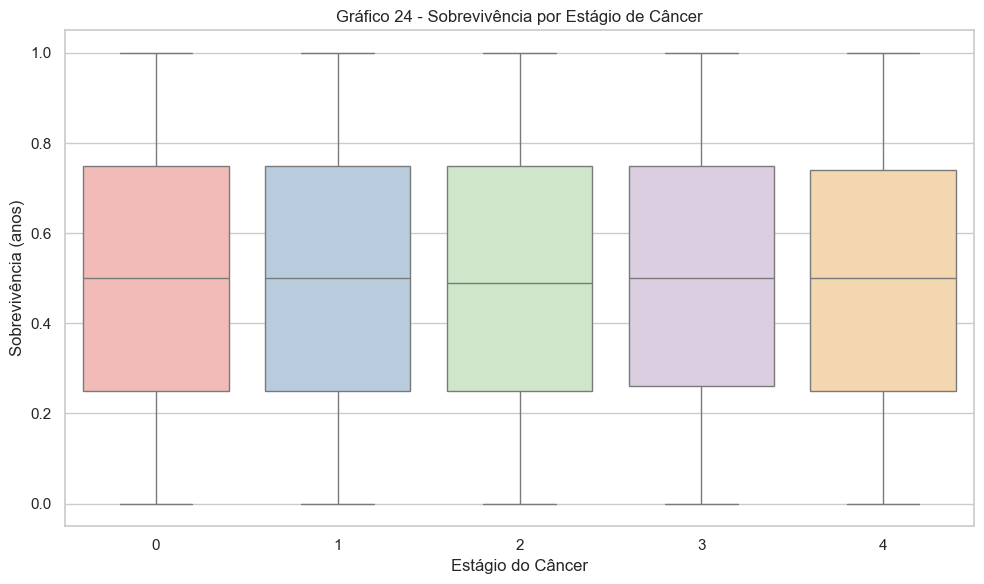

In [126]:
# Filtrar outliers com Z-score (colunas numéricas)
df_num = df.select_dtypes(include=['float64', 'int64'])
z_scores = stats.zscore(df_num)
df = df[(abs(z_scores) < 3).all(axis=1)]

df_encoded = df
df_decoded = df.copy

enconded_list = ['Gender', 'Country_Region', 'Cancer_Type']

for prefix in enconded_list:
    one_hot_cols = [col for col in df.columns if col.startswith(prefix + '_')]
    if not one_hot_cols:
        continue  
    df[prefix] = df[one_hot_cols].idxmax(axis=1).str.replace(f'{prefix}_', '')
    df.drop(columns=one_hot_cols, inplace=True)

def print_and_plot_avg(df, df_encoded):

    def add_values_on_bars(ax, values):
        for i, v in enumerate(values):
            ax.text(i, v + v*0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=9)

    # Gráfico 1 - Top 10 Tipos de Câncer por Média de Sobrevivência
    mean_survival = df.groupby('Cancer_Type')['Survival_Years'].mean().sort_values(ascending=False).head(10)
    plt.figure(figsize=(10,6))
    ax = sns.barplot(x=mean_survival.index, y=mean_survival.values, color='green')
    add_values_on_bars(ax, mean_survival.values)
    plt.title('Gráfico 1 - Top 10 Tipos de Câncer por Média de Sobrevivência')
    plt.xticks(rotation=45)
    plt.ylabel('Sobrevivência (anos)')
    plt.tight_layout()
    plt.show()

        # Gráfico 2 - Top 10 Tipos de Câncer por Custo Médio de Tratamento
    mean_cost = df.groupby('Cancer_Type')['Treatment_Cost_USD'].mean().sort_values(ascending=False).head(10)
    plt.figure(figsize=(10,6))
    ax = sns.barplot(x=mean_cost.index, y=mean_cost.values, color='gray')
    add_values_on_bars(ax, mean_cost.values)
    plt.title('Gráfico 2 - Top 10 Tipos de Câncer por Custo Médio de Tratamento')
    plt.xticks(rotation=45)
    plt.ylabel('Custo Médio (USD)')
    plt.tight_layout()
    plt.show()

    # Gráfico 3 - Top 10 Tipos de Câncer por Risco Genético Médio
    mean_risk = df.groupby('Cancer_Type')['Genetic_Risk'].mean().sort_values(ascending=False).head(10)
    plt.figure(figsize=(10,6))
    ax = sns.barplot(x=mean_risk.index, y=mean_risk.values, color='orange')
    add_values_on_bars(ax, mean_risk.values)
    plt.title('Gráfico 3 - Top 10 Tipos de Câncer por Risco Genético Médio')
    plt.xticks(rotation=45)
    plt.ylabel('Risco Genético')
    plt.tight_layout()
    plt.show()

    # Gráfico 4 - Top 10 Tipos de Câncer por Uso de Álcool
    mean_alcohol = df.groupby('Cancer_Type')['Alcohol_Use'].mean().sort_values(ascending=False).head(10)
    plt.figure(figsize=(10,6))
    ax = sns.barplot(x=mean_alcohol.index, y=mean_alcohol.values, color='red')
    add_values_on_bars(ax, mean_alcohol.values)
    plt.title('Gráfico 4 - Top 10 Tipos de Câncer por Uso de Álcool')
    plt.xticks(rotation=45)
    plt.ylabel('Uso de Álcool')
    plt.tight_layout()
    plt.show()

    # Gráfico 5 - Média de Sobrevivência por Gênero
    mean_survival_gender = df.groupby('Gender')['Survival_Years'].mean()
    plt.figure(figsize=(10,6))
    ax = sns.barplot(x=mean_survival_gender.index, y=mean_survival_gender.values, color='purple')
    add_values_on_bars(ax, mean_survival_gender.values)
    plt.title('Gráfico 5 - Média de Sobrevivência por Gênero')
    plt.ylabel('Sobrevivência (anos)')
    plt.tight_layout()
    plt.show()

    # Gráfico 6 - Top 10 Países por Custo Médio de Tratamento
    mean_cost_country = df.groupby('Country_Region')['Treatment_Cost_USD'].mean().sort_values(ascending=False).head(10)
    plt.figure(figsize=(10,6))
    ax = sns.barplot(x=mean_cost_country.index, y=mean_cost_country.values, color='purple')
    add_values_on_bars(ax, mean_cost_country.values)
    plt.title('Gráfico 6 - Top 10 Países por Custo Médio de Tratamento')
    plt.xticks(rotation=45)
    plt.ylabel('Custo Médio (USD)')
    plt.tight_layout()
    plt.show()

    # Gráfico 7 - Média da Idade por Estágio do Câncer
    mean_age_stage = df.groupby('Cancer_Stage')['Age'].mean()
    plt.figure(figsize=(10,6))
    ax = sns.barplot(x=mean_age_stage.index, y=mean_age_stage.values, color='blue')
    add_values_on_bars(ax, mean_age_stage.values)
    plt.title('Gráfico 7 - Média da Idade por Estágio do Câncer')
    plt.xlabel('Estágio')
    plt.ylabel('Idade Média')
    plt.tight_layout()
    plt.show()

    # Gráfico 8 - Distribuição da Idade dos Pacientes
    plt.figure(figsize=(10,6))
    sns.histplot(df['Age'], bins=15, color='lightgreen')
    plt.title('Gráfico 8 - Distribuição da Idade dos Pacientes')
    plt.xlabel('Idade')
    plt.ylabel('Quantidade')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # Gráfico 9 - Distribuição do Custo de Tratamento
    plt.figure(figsize=(10,6))
    sns.histplot(df['Treatment_Cost_USD'], bins=15, color='lightcoral')
    plt.title('Gráfico 9 - Distribuição do Custo de Tratamento')
    plt.xlabel('Custo (USD)')
    plt.ylabel('Quantidade')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # Gráfico 10 - Sobrevivência x Custo do Tratamento
    plt.figure(figsize=(10,6))
    plt.scatter(df['Treatment_Cost_USD'], df['Survival_Years'], alpha=0.5, color='purple')
    plt.title('Gráfico 10 - Sobrevivência x Custo do Tratamento')
    plt.xlabel('Custo (USD)')
    plt.ylabel('Sobrevivência (anos)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Gráfico 11 - Distribuição por Sexo (pizza)
    plt.figure(figsize=(6,6))
    sex_counts = df['Gender'].value_counts()
    sex_counts.plot.pie(autopct='%1.1f%%', colors=['lightblue', 'pink'], startangle=90)
    plt.title('Gráfico 11 - Distribuição por Sexo')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

    # Gráfico 12 - Mapa de Correlação com Target_Severity_Score
    import numpy as np

    df_num = df_encoded.select_dtypes(include='number')
    corr_matrix = df_num.corr()

    if 'Target_Severity_Score' in corr_matrix.columns:
        corr_target = (
            corr_matrix['Target_Severity_Score']
            .drop('Target_Severity_Score')
            .dropna()
            .sort_values(key=abs, ascending=False)
        )

        colors = ['#d62728' if val > 0 else '#1f77b4' for val in corr_target.values]

        plt.figure(figsize=(10, 6))
        sns.set(style="whitegrid")

        ax = sns.barplot(x=corr_target.values, y=corr_target.index, palette=colors)

        for i, val in enumerate(corr_target.values):
            ax.text(val + 0.01 if val > 0 else val - 0.08, i, f"{val:.2f}", va='center', color='black', fontsize=9)

        plt.title("Gráfico 12 - Correlação com Target_Severity_Score")
        plt.xlabel("Correlação")
        plt.ylabel("Variáveis")
        plt.tight_layout()
        plt.show()

    else:
        print("❌ A coluna 'Target_Severity_Score' não foi encontrada na matriz de correlação.")

    # Gráfico 13 - Média de Sobrevivência por categorias one-hot Gender
    gender_cols = [col for col in df_encoded.columns if col.startswith('Gender_')]
    for col in gender_cols:
        mean_surv = df_encoded.loc[df_encoded[col] == 1, 'Survival_Years'].mean()
        print(f'Gráfico 13 - Média de Sobrevivência para {col}: {mean_surv:.2f} anos')

    # Gráficos 14 a 19 - Scatter plots das variáveis mais correlacionadas ao Target_Severity_Score
    correl_vars = ['Smoking', 'Genetic_Risk', 'Alcohol_Use', 'Air_Pollution', 'Obesity_Level', 'Treatment_Cost_USD', 'Survival_Years']
    for i, var in enumerate(correl_vars, start=14):
        plt.figure(figsize=(8, 5))
        sns.regplot(x=df[var], y=df['Target_Severity_Score'], scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
        plt.title(f'Gráfico {i} - {var} x Target_Severity_Score')
        plt.xlabel(var)
        plt.ylabel('Target_Severity_Score')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Gráfico 20 - Pairplot das principais variáveis correlacionadas com Target_Severity_Score
    pairplot_vars = ['Target_Severity_Score', 'Smoking', 'Genetic_Risk', 'Alcohol_Use', 'Survival_Years']
    sns.pairplot(df[pairplot_vars], corner=True, plot_kws={'alpha':0.5})
    plt.suptitle('Gráfico 20 - Pairplot - Variáveis mais correlacionadas com Target_Severity_Score', y=1.02)
    plt.show()

    # Gráficos 21 e 22 - Boxplots comparando Target_Severity_Score por faixas de algumas variáveis
    def categorize(column, bins, labels):
        return pd.cut(df[column], bins=bins, labels=labels, include_lowest=True)
    
    std_bin = [-0.01, 0.25, 0.5, 0.75, 1.0]

    # Faixas de tabagismo
    df['Smoking_Level'] = categorize('Smoking', std_bin, labels=['Muito Baixo', 'Baixo', 'Moderado', 'Alto'])
    plt.figure(figsize=(8,6))
    sns.boxplot(x='Smoking_Level', y='Target_Severity_Score', data=df, palette='Reds')
    plt.title('Gráfico 21 - Target_Severity_Score por Nível de Tabagismo')
    plt.xlabel('Nível de Tabagismo')
    plt.ylabel('Target_Severity_Score')
    plt.tight_layout()
    plt.show()

    # Faixas de risco genético
    df['Genetic_Risk_Level'] = categorize('Genetic_Risk', std_bin, labels=['Muito Baixo', 'Baixo', 'Moderado', 'Alto'])
    plt.figure(figsize=(8,6))
    sns.boxplot(x='Genetic_Risk_Level', y='Target_Severity_Score', data=df, palette='Blues')
    plt.title('Gráfico 22 - Target_Severity_Score por Nível de Risco Genético')
    plt.xlabel('Nível de Risco Genético')
    plt.ylabel('Target_Severity_Score')
    plt.tight_layout()
    plt.show()

    # Gráfico 23 - Mapa de calor: severidade média por tipo de câncer e gênero
    pivot = df.pivot_table(index='Cancer_Type', columns='Gender', values='Target_Severity_Score', aggfunc='mean')
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot, annot=True, cmap='coolwarm', fmt=".1f", linewidths=0.5)
    plt.title('Gráfico 23 - Severidade Média por Tipo de Câncer e Gênero')
    plt.ylabel('Tipo de Câncer')
    plt.xlabel('Gênero')
    plt.tight_layout()
    plt.show()

    # Gráfico 24 - Exemplo extra: Boxplot da Sobrevivência por Estágio de Câncer (adicional)
    plt.figure(figsize=(10,6))
    sns.boxplot(x='Cancer_Stage', y='Survival_Years', data=df, palette='Pastel1')
    plt.title('Gráfico 24 - Sobrevivência por Estágio de Câncer')
    plt.xlabel('Estágio do Câncer')
    plt.ylabel('Sobrevivência (anos)')
    plt.tight_layout()
    plt.show()

# Executar tudo
print_and_plot_avg(df, df_encoded)